* Name: Alberto Zorzetto
* Email: alberto.zorzetto1@gmail.com
* UCSD PID: NA (13th grade , high school)

In [1]:
# !pip install neurodsp
# !pip install git+https://github.com/forrestbao/pyeeg.git
# !pip install fooof

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 88 kB 1.6 MB/s eta 0:00:011
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/forrestbao/pyeeg.git to /private/var/folders/wg/94j9k5cn175f96w8xqmncds9jx4k56/T/pip-req-build-e00_lyp9
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /private/var/folders/wg/94j9k5cn175f96w8xqmncds9jx4k56/T/pip-req-build-e00_lyp9
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28132 sha256=e77d4a0c8592c4625e4d13ce5ab3f91639ea2abd96ffe1802a65fe6baff64390
  Stored in directory: /private/var/folders/wg/94j9k5cn175f96w8xqmncds9jx4k56/T/pip-ephem-wheel-cache-5j_1mf4b/wheels/3b/4c/23/f148efd24c82659379aad76057fe18bfe4161d81bd44c080cb
Successfully built pyeeg
Looking in indexes: https://pypi.org/simple, 

In [4]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold,train_test_split
from skopt import gp_minimize
import lightgbm as lgb
from skopt.space import *
from sklearn.preprocessing import StandardScaler
import gc
from fooof import FOOOF
import scipy.stats as ss
import pyeeg
from sklearn.metrics import f1_score,roc_auc_score
from skopt.plots import *
import numpy as np # l
import pandas as pd 
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
import os
import pickle

%matplotlib inline

In [5]:
eeg_fs = 250 
eeg_ch = ["C3", "Cz", "C4"] 
eog_ch = ["EOG_ch01", "EOG_ch02", "EOG_ch03"] 
all_ch = eeg_ch + eog_ch
event_types = {0:"left", 1:"right"}

In [10]:
PATH="./ucsd"

In [11]:
train_df = pickle.load(open(PATH+"/epoched_train.pkl", "rb"))
test_df = pickle.load(open(PATH+"/epoched_test.pkl", "rb"))

In [12]:
train_df.columns=['patient_id', 'start_time', 'event_type', 'C3', 'Cz', 'C4', 'EOG_ch01',
       'EOG_ch02', 'EOG_ch03' ]
test_df.columns=['patient_id', 'start_time', 'C3', 'Cz', 'C4', 'EOG_ch01',
       'EOG_ch02', 'EOG_ch03']

In [13]:
train_df

patient_id  start_time event_type  \
0        B0101T    223556.0          0   
1        B0101T    232996.0          1   
2        B0101T    251268.0          0   
3        B0101T    259416.0          1   
4        B0101T    294924.0          1   
...         ...         ...        ...   
3675     B0903T   1790936.0          0   
3676     B0903T   1800012.0          1   
3677     B0903T   1810236.0          1   
3678     B0903T   1820720.0          0   
3679     B0903T   1831660.0          0   

                                                     C3  \
0     [-3.6285954070344086, -2.337682154573892, -3.6...   
1     [2.9480430304417484, -0.05493247882810711, 0.3...   
2     [-0.2380407415884641, -2.0721751735713743, -2....   
3     [-0.5554283970397498, -2.926680399786373, -4.9...   
4     [-2.8961623559929808, -2.352941176470588, -1.7...   
...                                                 ...   
3675  [4.151404151404152, 3.736263736263736, 3.22344...   
3676  [1.4163614163614164, 0.21978021978021972, -0.0...   
3677  [1.8559218559218558, 0.5860805860805861, -0.46...   
3678  [0.2686202686202686, 0.21978021978021972, -0.0...   
3679  [-0.5372405372405372, -0.46398046398046394, -2...   

                                                     Cz  \
0     [-2.920576791027695, -2.47501335164416, -2.548...   
1     [4.437323567559321, 2.4872205691615163, 0.9674...   
2     [2.825970855268177, 3.308155947203784, 1.83718...   
3     [5.743495841916532, 4.785229266803998, 3.40581...   
4     [2.8442816815442127, 2.7557793545433737, 2.075...   
...                                                 ...   
3675  [2.7594627594627594, 2.9792429792429798, 2.686...   
3676  [2.686202686202685, 2.1978021978021984, 1.7338...   
3677  [0.2686202686202686, 0.9768009768009768, 0.610...   
3678  [2.3443223443223444, 2.148962148962149, 3.6385...   
3679  [0.09768009768009768, 0.3418803418803419, 0.29...   

                                                     C4  \
0     [5.502403295948728, 6.485084306095978, 6.68955...   
1     [1.3855191882200348, -0.4699778744182498, 0.44...   
2     [-0.9155413138017852, -0.5645838101777675, -2....   
3     [0.9155413138017852, 1.541161211566339, 1.0284...   
4     [-0.8331425955596247, -0.32349126420996416, 0....   
...                                                 ...   
3675  [4.493284493284493, 3.345543345543345, 4.39560...   
3676  [0.31746031746031744, -0.46398046398046394, 0....   
3677  [1.0256410256410255, 0.7081807081807082, 2.222...   
3678  [3.736263736263736, 4.615384615384613, 4.20024...   
3679  [-2.5641025641025643, -0.31746031746031744, -0...   

                                               EOG_ch01  \
0     [7.354848554207674, 4.699778744182498, 8.39246...   
1     [-18.127718013275352, 18.188754100862134, -5.8...   
2     [-8.331425955596247, -15.7778286411841, -1.922...   
3     [6.6224155031662475, 3.1128404669260696, 11.74...   
4     [7.2938124666208894, -2.655069810025177, 7.110...   
...                                                 ...   
3675  [-4.395604395604395, 0.9768009768009768, -3.41...   
3676  [7.814407814407812, 5.86080586080586, 1.465201...   
3677  [-17.094017094017097, 7.326007326007326, 0.488...   
3678  [4.395604395604395, 1.4652014652014649, 19.536...   
3679  [11.72161172161172, 0.4884004884004883, 6.8376...   

                                               EOG_ch02  \
0     [5.676356145571068, 10.2235446707866, 16.08300...   
1     [-14.373998626688028, 21.484702830548557, -6.2...   
2     [-1.9226367589837492, -9.552147707331956, -6.6...   
3     [-1.6174563210498203, -2.349889372091249, 9.00...   
4     [7.934691386282138, 0.18310826276035705, 12.93...   
...                                                 ...   
3675  [14.652014652014651, 7.814407814407812, 5.3724...   
3676  [9.27960927960928, 10.256410256410255, 1.95360...   
3677  [-15.140415140415142, 20.51282051282051, -6.34...   
3678  [12.210012210012207, -1.953601953601953, 11.72...   
3679  [11.23321

In [14]:
y_train=train_df['event_type']
y_train

0       0
1       1
2       0
3       1
4       1
       ..
3675    0
3676    1
3677    1
3678    0
3679    0
Name: event_type, Length: 3680, dtype: object

In [15]:
X_train=train_df.drop(['event_type','patient_id','start_time'],axis=1,inplace=False)
X_test=test_df.drop(['patient_id','start_time'],axis=1,inplace=False)

# Data Visualization

In [16]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [17]:
def sample_plot_psd(df, n_samples=6):
    if n_samples % 2 == 1:
        raise ValueError("number not even")
    fig,axs=plt.subplots(1,#C3,C4,Cz
                        n_samples,figsize=(20,5),dpi= 200)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    random_samples_idxs=np.random.choice(X_train.shape[0],n_samples)
    for n,idx in enumerate(random_samples_idxs):
        label=df.loc[idx,'event_type']
        ax_title="left" if label == 0 else "right"
        axs[n].set_title(ax_title)
        axs[n].plot(moving_average(df.loc[idx]['C3'], w=300),color='red',label="C3")
        axs[n].plot(moving_average(df.loc[idx]['C4'], w=300),color='blue',label="C4")
        axs[n].plot(moving_average(df.loc[idx]['Cz'], w=300 ),color='green',label="Cz")
        axs[n].legend()
        
    plt.legend()
    plt.show()

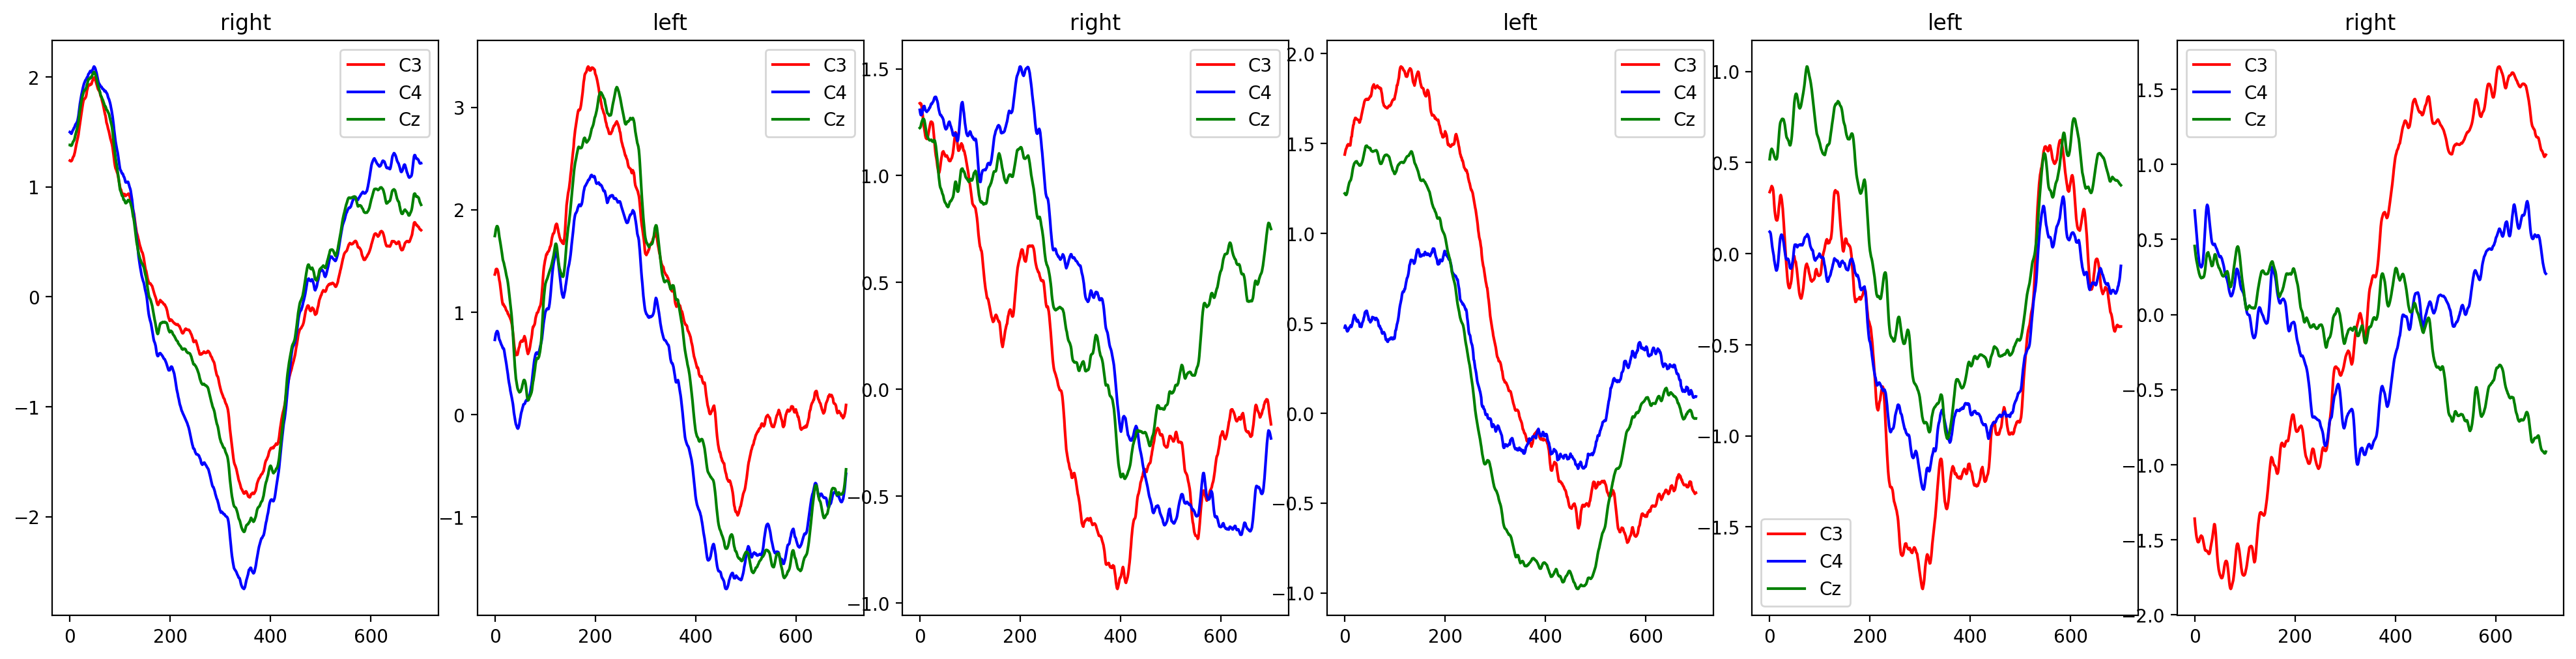

In [18]:
sample_plot_psd(train_df)

In [19]:
def sample_plot_psd_spectrum(df,n_samples=6):
    fig,axs=plt.subplots(1,n_samples,figsize=(20,5),dpi= 200)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    random_samples_idxs=np.random.choice(X_train.shape[0],n_samples)
    for n,idx in enumerate(random_samples_idxs):
        label=df.loc[idx,'event_type']
        ax_title="left" if label == 0 else "right"
        axs[n].set_title(ax_title)
        axs[n].plot(compute_spectrum(df.loc[idx]['C3'], eeg_fs, method='welch', avg_type='mean', nperseg=eeg_fs*2)[1],color='green',label="C3")
        axs[n].legend()
        
    plt.legend()
    plt.show()

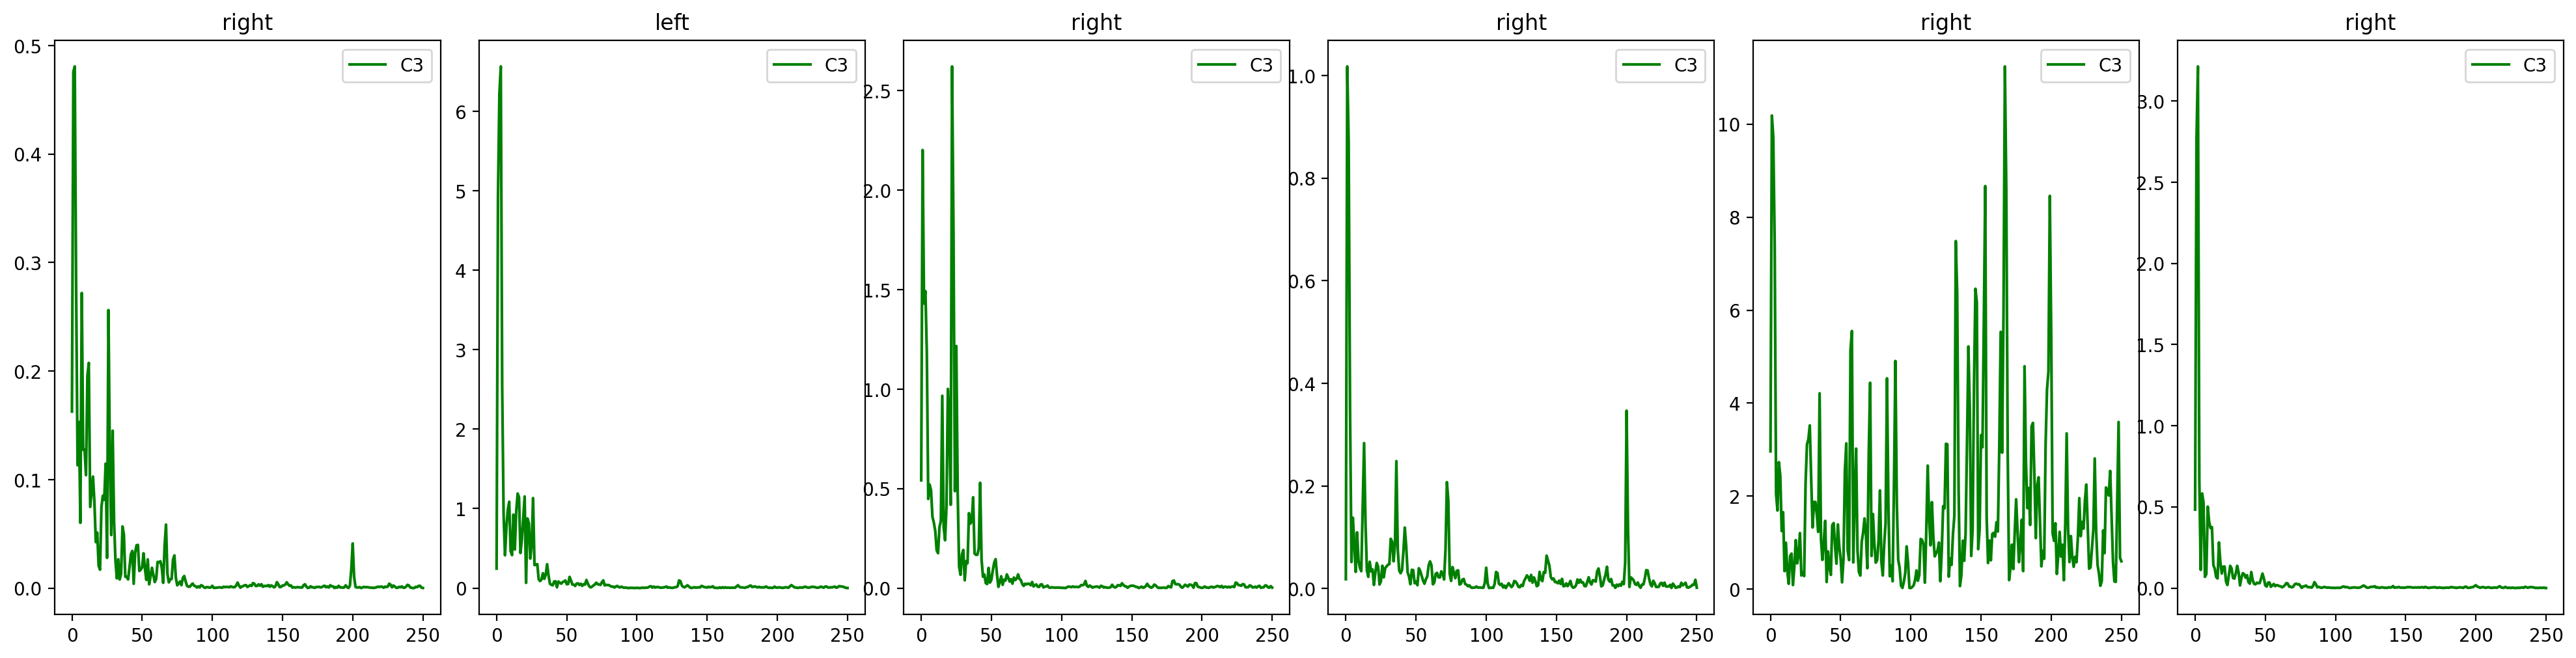

In [20]:
sample_plot_psd_spectrum(train_df)

In [21]:
sig = train_df['C3'][0]
alpha_range = (7, 12)

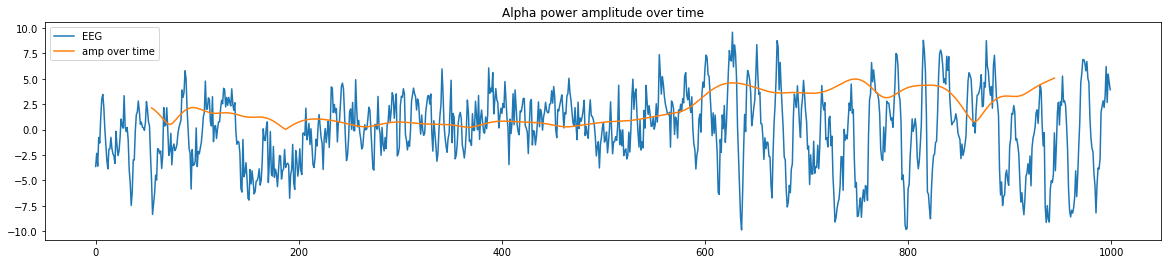

In [22]:
amp = amp_by_time(sig, eeg_fs, alpha_range)
plt.figure(figsize=(20,4))
plt.plot(sig, label="EEG")
plt.plot(amp, label="amp over time")
plt.legend()
plt.title("Alpha power amplitude over time")
plt.show()

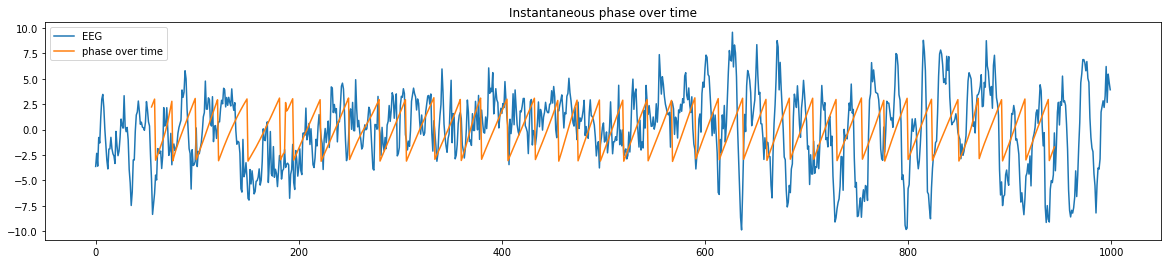

In [23]:
phase = phase_by_time(sig, eeg_fs, alpha_range)
plt.figure(figsize=(20,4))
plt.plot(sig, label="EEG")
plt.plot(phase, label="phase over time")
plt.legend()
plt.title("Instantaneous phase over time")
plt.show()

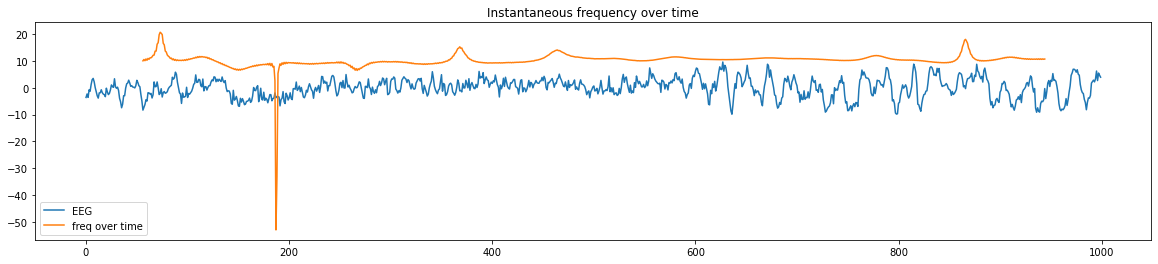

In [24]:
i_f = freq_by_time(sig, eeg_fs, alpha_range)
plt.figure(figsize=(20,4))
plt.plot(sig, label="EEG")
plt.plot(i_f, label="freq over time")
plt.legend()
plt.title("Instantaneous frequency over time")
plt.show()

# Feature Extraction

i implemented this feature extraction methods after following these videos:

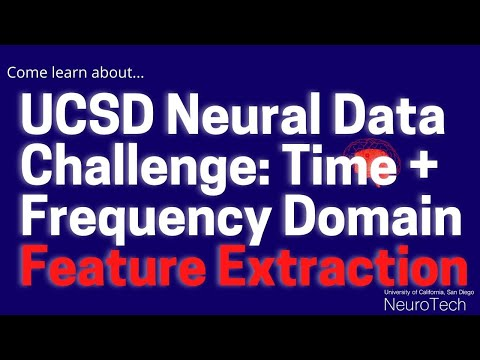

In [25]:
from IPython.display import YouTubeVideo
YouTubeVideo('4lmPKQDTWs4', width=400, height=250)

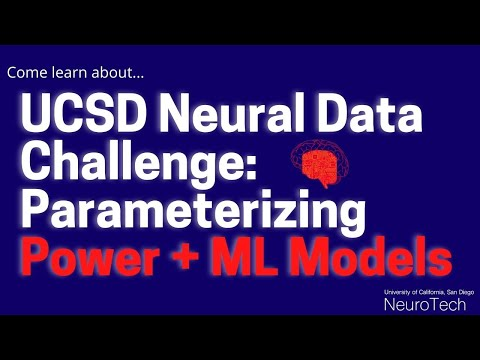

In [26]:
YouTubeVideo('rvdR4MRVaYk', width=400, height=250)

of course since this is my first time working with EEGs i was heavily dependent on the course material on this one :C

In [27]:
binning=[0.5, 4, 7, 12, 30]
intervals=["05_4","4_7","7_12","12_30"]

In [28]:
def extract_power_ratio(data,binning=[0.5, 4, 7, 12, 30],eeg_fs=250):
    global intervals
    result = pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    for idx,row in data.iterrows():
        for ch in all_ch:
            _ , p_ratios=pyeeg.bin_power(row[ch],binning,eeg_fs)
            p_ratios=np.array(p_ratios)
            for n,ratio in enumerate(p_ratios):
                c_name=str(ch+"_"+intervals[n])
                result.loc[idx,c_name]=ratio
    return result

In [29]:
def extract_C3_C4_diff(data):
    global intervals
    result = pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    for idx,row in data.iterrows():
        for interval in intervals:
            result.loc[idx,str("C3_C4_" + interval + "_difference")]=data.loc[idx,'C3_' + interval ] - data.loc[idx,'C4_' + interval ]
            result.loc[idx,str("Cz_C3_" + interval + "_difference")]= data.loc[idx,'Cz_' + interval ] - data.loc[idx,'C3_' + interval ]
            result.loc[idx,str("Cz_C4_" + interval + "_difference")]= data.loc[idx,'Cz_' + interval ] - data.loc[idx,'C4_' + interval ]
    return result

In [30]:
def extract_band_ratios(data):
    result = pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    delta_suffix="_05_4"
    theta_suffix="_4_7"
    alpha_suffix="_7_12"
    beta_suffix="_12_30"
    for idx,row in data.iterrows():
        for ch in all_ch:
            
            #i know i could've iterated trough the permutations but they were few anyway
            
            delta_alpha_ratio=data.loc[idx,str(ch+delta_suffix)]/data.loc[idx,str(ch+alpha_suffix)]
            theta_beta_ratio=data.loc[idx,str(ch+theta_suffix)]/data.loc[idx,str(ch+beta_suffix)]
            delta_beta_ratio=data.loc[idx,str(ch+delta_suffix)]/data.loc[idx,str(ch+beta_suffix)]
            theta_alpha_ratio=data.loc[idx,str(ch+theta_suffix)]/data.loc[idx,str(ch+alpha_suffix)]
            beta_alpha_ratio=data.loc[idx,str(ch+beta_suffix)]/data.loc[idx,str(ch+alpha_suffix)]
            theta_delta_ratio=data.loc[idx,str(ch+theta_suffix)]/data.loc[idx,str(ch+delta_suffix)]
            
            
            result.loc[idx,str(ch+"_delta_alpha_ratio")] = delta_alpha_ratio
            result.loc[idx,str(ch+"_theta_beta_ratio")] = theta_beta_ratio
            result.loc[idx,str(ch+"_delta_alpha_ratio")] = delta_alpha_ratio
            result.loc[idx,str(ch+"_delta_beta_ratio")] = delta_beta_ratio
            result.loc[idx,str(ch+"_beta_alpha_ratio")] = beta_alpha_ratio
            result.loc[idx,str(ch+"_theta_delta_ratio")] = theta_delta_ratio
    return result

In [31]:
def first_order_diff(X):
    r=[]
    for i in range(len(X)-2):
        r.append(X[i+1]-X[i])
    return np.array(r)

In [32]:
def extract_first_second_diff_avg_max(data):
    global intervals
    result = pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    for idx,row in data.iterrows():
        for ch in all_ch:
            fod_ch=first_order_diff(row[ch])
            result.loc[idx, str( ch + "_1st_order_diff_max")] = np.amax(fod_ch)
            result.loc[idx, str( ch + "_1st_order_diff_avg")] = np.mean(fod_ch)
            
            result.loc[idx, str( ch + "_2nd_order_diff_max")] = np.amax(first_order_diff(fod_ch))
            result.loc[idx, str( ch + "_2ndorder_diff_avg")] = np.mean(first_order_diff(fod_ch))
    return result

In [33]:
def extract_hjorth(data):
    result = pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    for idx,row in data.iterrows():
        for ch in all_ch:
            hj1,hj2=pyeeg.hjorth(row[ch])
            result.loc[idx,str(ch + "_hjorth_mobility")] = hj1
            result.loc[idx,str(ch + "_hjorth_complexity")] = hj2
            
            #fod_hj1,fod_hj2=pyeeg.hjorth(row[ch],list(first_order_diff(row[ch])))
            #result.loc[idx,str(ch +  "_1st_ord_diff_hjorth_mobility")] = fod_hj1
            #result.loc[idx,str(ch +"_1st_ord_diff_hjorth_complexity")] = fod_hj2
    return result

In [34]:
def extract_detrended_fluctuation_analysis(data):
    result = pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    for idx,row in data.iterrows():
        for ch in all_ch:
            result.loc[idx,str(ch+"_dfa")]=pyeeg.dfa(row[ch])
    return result

In [35]:
def extract_stat_features(data):
    e=pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    for idx,row in data.iterrows():
        for feature in data.columns:
            e.loc[idx,f'{feature}_mean']=ss.tmean(row[feature])
            e.loc[idx,f'{feature}_std'] =ss.tstd(row[feature])
            e.loc[idx,f'{feature}_kurt']=ss.kurtosis(row[feature])
            e.loc[idx,f'{feature}_skew']=ss.skew(row[feature])
            e.loc[idx,f'{feature}_min'] =ss.tmin(row[feature])
            e.loc[idx,f'{feature}_var'] =ss.tvar(row[feature])
            e.loc[idx,f'{feature}_median']=ss.median_absolute_deviation (row[feature]) #e.loc[idx,f'{feature}_sem'] =ss.tsem(row[feature])            
    return e

In [36]:
def extract_neurodsp_stuff(data,f_ranges=[(4,7),(7,12)]):
    global intervals
    result = pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    for idx,row in data.iterrows():
        for ch in all_ch:
            for i,frange in enumerate(f_ranges):
                amp = amp_by_time(row[ch],eeg_fs,frange)
                i_f = freq_by_time(row[ch], eeg_fs, frange)
                
                result.loc[idx,str(ch+"_"+intervals[i]+"-"+"amp_time_median")]=np.nanmedian(amp)
                result.loc[idx,str(ch+"_"+intervals[i]+"-"+"amp_time_max")]=np.nanmax(amp)
                result.loc[idx,str(ch+"_"+intervals[i]+"-"+"amp_time_min")]=np.nanmin(amp)
                result.loc[idx,str(ch+"_"+intervals[i]+"-"+"amp_time_kurt")]=ss.kurtosis(amp,nan_policy='omit')
                
                
                result.loc[idx,str(ch+"_"+intervals[i]+"-"+"freq_time_median")]=np.nanmedian(i_f)
                result.loc[idx,str(ch+"_"+intervals[i]+"-"+"freq_time_max")]=np.nanmax(i_f)
                result.loc[idx,str(ch+"_"+intervals[i]+"-"+"freq_time_min")]=np.nanmin(i_f)
                result.loc[idx,str(ch+"_"+intervals[i]+"-"+"freq_time_kurt")]=ss.kurtosis(i_f,nan_policy='omit')

    return result

In [37]:
def extract_fooof(data,freq_range = [1, 40] ):
    result = pd.DataFrame(index=range(data.shape[0]),dtype=np.float64)
    alpha_range=(7, 12)
    fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.4)
    num_with_alpha = 0
    num_without_alpha = 0
    for idx,row in data.iterrows():
            for ch in all_ch:
                
                freq, psd = compute_spectrum(data.loc[idx]['C3'], eeg_fs, method='welch',
                                avg_type='mean', nperseg=eeg_fs*2)
                fm.add_data(freq, psd, freq_range)
                fm.fit()
                peak_params = fm.peak_params_
                
                peak_params_alpha = []
                for param in peak_params: 
                    if (param[0] > alpha_range[0]) and (param[0] < alpha_range[1]): 
                        peak_params_alpha.append(param)
                means = []
                if len(peak_params_alpha) > 0: 
                    num_with_alpha += 1
                    means = np.mean(peak_params_alpha, axis=0)
                else :
                    num_without_alpha += 1
                    means = [0, 0, 0]

                result.loc[idx,ch + "_alpha_central_freq"]=means[0]
                result.loc[idx, ch + "_alpha_power"]=means[1]
                result.loc[idx,ch + "_alpha_band_width"]=means[2]
    return result

In [ ]:
#%%time
p_ratios=extract_power_ratio(X_train)
X_train=(p_ratios.join(extract_stat_features(X_train))
        .join(extract_hjorth(X_train))
        .join(extract_neurodsp_stuff(X_train))
        .join(extract_detrended_fluctuation_analysis(X_train))
        .join(extract_first_second_diff_avg_max(X_train))
        .join(extract_C3_C4_diff(p_ratios))
        .join(extract_band_ratios(p_ratios))
        .join(extract_fooof(X_train))
       )
X_train

/var/folders/wg/94j9k5cn175f96w8xqmncds9jx4k56/T/ipykernel_9468/2776642745.py:11: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  e.loc[idx,f'{feature}_median']=ss.median_absolute_deviation (row[feature]) #e.loc[idx,f'{feature}_sem'] =ss.tsem(row[feature])
/opt/anaconda3/lib/python3.8/site-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1

In [ ]:
#p_ratios=extract_power_ratio(X_test)
X_test=(p_ratios.join(extract_stat_features(X_test))
        .join(extract_hjorth(X_test))
        .join(extract_neurodsp_stuff(X_test))
        .join(extract_detrended_fluctuation_analysis(X_test))
        .join(extract_first_second_diff_avg_max(X_test))
        .join(extract_C3_C4_diff(p_ratios))
        .join(extract_band_ratios(p_ratios))
       .join(extract_fooof(X_test))

)
X_test

In [40]:
X_train.to_csv("./ucsd/train.csv")
X_test.to_csv("./ucsd/test.csv")
#del X_train,X_test

In [41]:
X_train=pd.read_csv("../input/eegucsddata/train.csv")
X_test=pd.read_csv("../input/eegucsddata/test.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../input/eegucsddata/train.csv'

In [36]:
X_train=X_train.iloc[:,1:]
X_test=X_test.iloc[:,1:]

In [37]:
scaler=StandardScaler()
scaler.fit(X_train)
prev=X_train.columns
X_train=pd.DataFrame(scaler.transform(X_train),columns=prev)
X_test=scaler.transform(X_test)

In [38]:
X_trn,X_val,y_trn,y_val=train_test_split(X_train,y_train,train_size=0.75,shuffle=True,random_state=23)

In [39]:
y_trn=y_trn.values.astype(np.int8)
y_val=y_val.values.astype(np.int8)

# Bayesian Optimiation on LightGBM

In [40]:
space  = [Integer(50,1000, name='max_depth'),
          Integer(200,3000, name='num_leaves'),
          Integer(5, 300, name='min_child_samples'),
          Real(1, 400,  name='scale_pos_weight'),
          Real(0.6,1, name='subsample'),
          Real(0.3, 0.9, name='colsample_bytree'),
          Integer(40, 500, name='max_bin'),
          Real(0.01, 20,  name='reg_alpha'),
          Real(0.01, 20,  name='reg_lambda'),
         ]

In [41]:
gc.collect()

39846

In [42]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True


In [43]:
def objective(hyp):
    params={
        'max_depth':hyp[0],
        'num_leaves':hyp[1],
        'min_child_samples' : hyp[2],
        'scale_pos_weight' :  hyp[3],
        'subsample':hyp[4],
        'colsample_bytree' :hyp[5],
        'learning_rate':0.01,
        'objective':'binary',
        'metrics':'auc',
        'max_bin':hyp[6],
        'nthread': 8,
        'boosting_type': 'gbdt',
        'min_child_weight': 0,
        'min_split_gain': 0,
        'subsample_freq': 1,
        'reg_alpha':hyp[7],
        'reg_lambda':hyp[8]
    }
    features_list=list(X_trn.columns)
    dtrain=lgb.Dataset(X_trn.values,label=y_trn,feature_name=features_list)
    dval=lgb.Dataset(X_val.values,label=y_val,feature_name=features_list)
    
    early_stopping=70
    num_boost_round=1500
    
    model_lgb=lgb.train(params,dtrain,valid_sets=(dtrain,dval),
                         valid_names=['train','valid'],num_boost_round=num_boost_round,
                                early_stopping_rounds=early_stopping,
                               verbose_eval=1, feval=lgb_f1_score)
    
    y_hat=model_lgb.predict(X_val[model_lgb.feature_name()])
    auc =-roc_auc_score(y_val,y_hat)
    gc.collect()
    print("AUC : ",auc,"\n")
    return auc

In [44]:
res_gp = gp_minimize(objective, space, n_calls=20,
                     random_state=23,n_initial_points=4)

[1]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
Training until validation scores don't improve for 70 rounds
[2]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[3]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[4]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[5]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[6]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[7]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[8]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[9]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[10]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[11]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[12]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[13]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[14]	train's auc: 0.5	train's f1: 0	valid's auc: 0.5	valid's f1: 0
[15]	train

In [45]:
"Best score=%.4f" % res_gp.fun

'Best score=-0.8484'

In [46]:
res_gp.x

[1000, 3000, 5, 1.0, 1.0, 0.3, 40, 0.01, 0.01]

# Training and Predict

In [47]:
hyp=res_gp.x


 
params={
    'max_depth':hyp[0],
    'num_leaves':hyp[1],
    'min_child_samples' : hyp[2],
    'scale_pos_weight' :  hyp[3],
    'subsample':hyp[4],
    'colsample_bytree' :hyp[5],
    'objective':'binary',
    'metrics':'auc',
    'max_bin':hyp[6],
    'nthread': 8,
    'learning_rate':0.1,
    'boosting_type': 'gbdt',
    'min_child_weight': 0,
    'min_split_gain': 0,
    'subsample_freq': 1,
    'reg_alpha':hyp[7],
    'reg_lambda':hyp[8]
}

splits=5

preds=np.zeros(X_test.shape[0])
history=[]

kfold=KFold(splits,shuffle=True,random_state=23)

for n_fold,(trn_idx,val_idx) in enumerate(kfold.split(train_df)):
    print(f"Fold #{n_fold}:\n")
    X_trn,y_trn=X_train.loc[trn_idx,:],y_train[trn_idx]
    X_val,y_val=X_train.loc[val_idx,:],y_train[val_idx]
    
    features_list=list(X_trn.columns)
    dtrain=lgb.Dataset(X_trn.values,label=y_trn.astype(np.int8),feature_name=features_list)
    dval=lgb.Dataset(X_val.values,label=y_val.astype(np.int8),feature_name=features_list)
    
    early_stopping=300
    num_boost_round=3000
    
    evals_result={}
    model_lgb=lgb.train(params,dtrain,valid_sets=(dtrain,dval),
                        evals_result=evals_result, valid_names=['train','valid'],num_boost_round=num_boost_round,
                               verbose_eval=1, feval=lgb_f1_score)
    history.append(evals_result)
    y_fold_preds=model_lgb.predict(X_test,num_iteration=model_lgb.best_iteration)
    preds+=np.asarray(y_fold_preds)

Fold #0:

[1]	train's auc: 0.975961	train's f1: 0.90455	valid's auc: 0.666541	valid's f1: 0.621586
[2]	train's auc: 0.997929	train's f1: 0.978358	valid's auc: 0.693288	valid's f1: 0.635995
[3]	train's auc: 0.999917	train's f1: 0.993844	valid's auc: 0.723153	valid's f1: 0.664915
[4]	train's auc: 0.999993	train's f1: 0.998631	valid's auc: 0.732191	valid's f1: 0.666667
[5]	train's auc: 1	train's f1: 0.999316	valid's auc: 0.732568	valid's f1: 0.656836
[6]	train's auc: 1	train's f1: 1	valid's auc: 0.744783	valid's f1: 0.660352
[7]	train's auc: 1	train's f1: 1	valid's auc: 0.751131	valid's f1: 0.688086
[8]	train's auc: 1	train's f1: 1	valid's auc: 0.762282	valid's f1: 0.690027
[9]	train's auc: 1	train's f1: 1	valid's auc: 0.76939	valid's f1: 0.700265
[10]	train's auc: 1	train's f1: 1	valid's auc: 0.771947	valid's f1: 0.699865
[11]	train's auc: 1	train's f1: 1	valid's auc: 0.777172	valid's f1: 0.707895
[12]	train's auc: 1	train's f1: 1	valid's auc: 0.782234	valid's f1: 0.7107
[13]	train's auc

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: more than one metric available, picking one to plot.
  """Entry point for launching an IPython kernel.


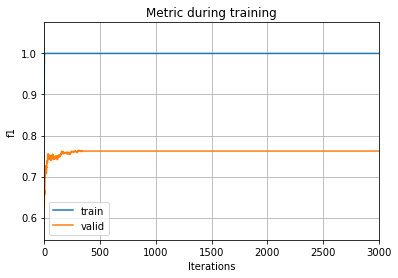

In [48]:
lgb.plot_metric(history[model_lgb.best_iteration])

In [49]:
lgb.plot_importance(model_lgb,height=1,figsize=(50,50),dpi=300)

In [50]:
preds /= splits

In [51]:
preds

array([9.99559654e-01, 1.87415450e-02, 9.99988549e-01, ...,
       7.35920233e-02, 5.27194349e-04, 1.56852021e-02])

In [52]:
sub=pd.DataFrame({'trial_id' : range(test_df.shape[0])})
sub['event_type']=np.round(preds).astype(int)
#sub.to_csv('submission.csv' ,index=False)

In [54]:
sub

trial_id  event_type
0            0           1
1            1           0
2            2           1
3            3           1
4            4           0
...        ...         ...
2835      2835           1
2836      2836           0
2837      2837           0
2838      2838           0
2839      2839           0

[2840 rows x 2 columns]